# <div align="center">Linear approximation of $\sqrt{1+x}$ where $x \in [0,1]$</div>
---------------------------------------------------------------------

In [24]:
import pandas as pd

import numpy as np
from numpy.linalg import inv

from matplotlib import pyplot as plt
plt.style.use(['ggplot'])
%matplotlib inline
fig = plt.figure(figsize = (16,8))

from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

import tensorflow as tf
print('tensorflow versio: ', tf.__version__)

import warnings
warnings.filterwarnings('ignore')

tensorflow versio:  1.14.0


<Figure size 1152x576 with 0 Axes>

In [2]:
np.random.seed(22)
tf.set_random_seed(22)

In [3]:
# Number of data points 
n = 10000

In [4]:
X = np.random.random(n).reshape((n, 1))
y = np.sqrt(1+X)

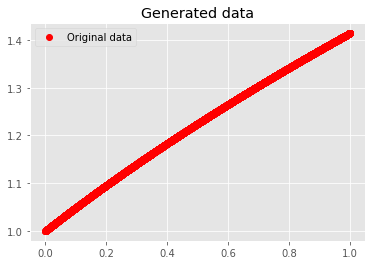

In [5]:
plt.plot(X, y, 'ro', label ='Original data')
plt.title('Generated data')
plt.legend()
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

# 1. With closed-form:

For linear regression on a model of the form $y=X \beta$, where $X$ is a matrix with ***full column rank***, the least squares solution,

$\hat{\beta}=argmin||X \beta - y||_{2}$

is given by

$\hat{\beta}=(X^{T}X)^{-1}X^{T}y$

Here requires the inversion of $X^{T}X$. If this matrix is not of full rank (i.e. there are linearly dependent columns) or if it is poorly conditioned (i.e. eigen values which are very close to zero) then the inversion can either be impossible, or numerically unstable.

A solution is to add a small element to the diagonal such that the eigen-values (and the matrix) are better conditioned

$\hat{\beta} = (X^{T}X+ \lambda^{2} I_{n})^{-1}X^{T}y$

This is actually the solution to the following quadratic cost function:

$J(\beta)=(y - X \beta )^{T} (y - X \beta) + \lambda^{2} \beta ^{T} \beta$

This is proven as follows:

$J(\beta)=(y - X \beta )^{T} (y - X \beta) + \lambda^{2} \beta ^{T} \beta = 
(y^{T} - \beta^{T} X^{T} ) (y - X \beta) + \lambda^{2} \beta ^{T} \beta = 
y^{T}y - y^{T}X \beta - \beta^{T} X^{T}y + \beta^{T} X^{T}X \beta + \lambda^{2} \beta ^{T} \beta = 
y^{T}y - 2\beta^{T} X^{T}y + \beta^{T} X^{T}X \beta + \lambda^{2} \beta ^{T} \beta$

Then Calculate gradient by $\beta$ and we will obtain above mentioned equation.

In [7]:
# create vector of ones
int = np.ones(shape=y_train.shape[0])[..., None]

#and add to feature matrix
X_train_with_ones = np.concatenate((int, X_train), 1)

In [8]:
# # calculate coefficients using closed-form solution
# coeffs = inv(X_train_with_ones.transpose().dot(X_train_with_ones)).dot(X_train_with_ones.transpose()).dot(y_train)

In [9]:
def closed_form_reg_solution(X, y, lamda = 0.1): 
    '''
    Closed form solution for ridge regression
    
    Parameters:
        X (list or nd.array) - actual inputs
        y (list or nd.array) - actual labels
        lambda(float)
        
    Returns:
        list (coefficients)
    '''
    m,n = X.shape
    I = np.eye((n))
    return (inv(X.transpose().dot(X) + lamda * I)).dot(X.transpose()).dot(y)[:,0]

In [10]:
def mse(actual, predicted):
    """
    Calculate mean squared error
    
    Parameters:
        actual (nd.array) - actual values
        predicted (nd.array) - predicted values
    
    Return:
        float(mse)
    """
    return (np.square(actual - predicted)).mean()

In [12]:
lambdas = [0.01, 0.1, 1, 10]
mse_s = []
for i in range(len(lambdas)):
    coeffs = closed_form_reg_solution(X_train_with_ones, y_train, lamda=lambdas[i])
    prediction = coeffs[0] * X_val + coeffs[1]
    mse_s.append(mse(y_val,prediction ))

In [13]:
best_lambda_index = np.argmin(mse_s)

In [15]:
best_lambda = lambdas[best_lambda_index]

In [16]:
coeffs = closed_form_reg_solution(X_train_with_ones, y_train, lamda=best_lambda)

In [17]:
print('Intercept:       {:0.2f},\nTheta1:          {:0.2f}'.format(coeffs[0],coeffs[1]))
print('Approximated function: ', np.round(coeffs[0], 2), '+', np.round(coeffs[1], 2), '*X' )

Intercept:       1.01,
Theta1:          0.41
Approximated function:  1.01 + 0.41 *X


MSE in Test dataset:  3.09870903287951e-05


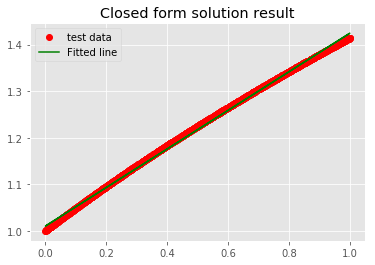

In [19]:
prediction = coeffs[1] * X_test + coeffs[0]

print('MSE in Test dataset: ', mse(y_test, prediction))

plt.plot(X_test, y_test, 'ro', label ='test data')
plt.plot(X_test, prediction, label ='Fitted line', color='green')
plt.title('Closed form solution result')
plt.legend()
plt.show()

# 2. With sklearn

In [34]:
lambdas = [0.01, 0.1, 1, 10]
mse_s = []
for i in range(len(lambdas)):
    regressor = Ridge(alpha=a, random_state=42)
    regressor.fit(X_train, y_train)
    prediction = regressor.predict(X_val)
    mse_s.append(mse(y_val, prediction ))

In [35]:
best_lambda_index = np.argmin(mse_s)

In [36]:
best_lambda = lambdas[best_lambda_index]

In [38]:
regressor = Ridge(alpha=best_lambda, random_state=42)
regressor.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

In [41]:
print('Intercept:       {:0.2f},\nTheta1:          {:0.2f}'.format(regressor.intercept_[0],regressor.coef_[0, 0]))
print('Approximated function: ', np.round(regressor.intercept_[0], 2), '+', np.round(regressor.coef_[0, 0], 2), '*X' )

Intercept:       1.01,
Theta1:          0.41
Approximated function:  1.01 + 0.41 *X


MSE in Test dataset:  2.807983644111036e-05


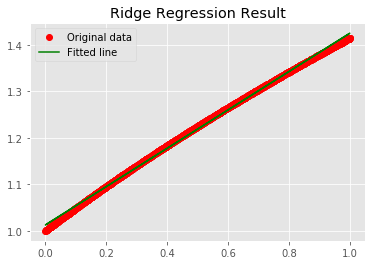

In [40]:
prediction = regressor.predict(X_test)

print('MSE in Test dataset: ', mse(y_test, prediction))

plt.plot(X_test, y_test, 'ro', label ='Original data')
plt.plot(X_test, prediction, label ='Fitted line', color='green')
plt.title('Ridge Regression Result')
plt.legend()
plt.show()

# 3. With Implemented gradient descent

<b>Gradient</b>

\begin{equation}
\frac{\partial J(\theta)}{\partial \theta_j} = 1/m\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_j^{(i)}
\end{equation}

<b>Gradients</b>
\begin{equation}
\theta_0: = \theta_{0} -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_0^{(i)})
\end{equation}
\begin{equation}
\theta_1: = \theta_{1} -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_1^{(i)})
\end{equation}
\begin{equation}
\theta_2: = \theta_{2} -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_2^{(i)})
\end{equation}

\begin{equation}
\theta_j: = \theta_{j} -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_0^{(i)})
\end{equation}

In [ ]:
def gradient_descent(X, y, theta, learning_rate=0.01, iterations=100):
    '''
    Parameters:
        X     = Matrix of X with added bias units
        y     = Vector of Y
        theta = Vector of thetas
        learning_rate 
        iterations = no of iterations
    
    Returns:
        np.array - (Returns the final theta vector and array of cost history over no of iterations)
    '''
    m = len(y)
    for it in range(iterations):
        
        prediction = np.dot(X,theta)
        
        theta = theta -(1/m)*learning_rate*( X.T.dot((prediction - y)))
    return theta

In [ ]:
lr =0.01
n_iter = 100000

theta = np.random.randn(2,1)

theta = gradient_descent(X, y, theta, lr, n_iter)

print('Theta0:          {:0.2f},\nTheta1:          {:0.2f}'.format(theta[0,0], theta[1,0]))
print('Approximated function: ', np.round(theta[0,0], 2), '+', np.round(theta[1,0], 2), '*X' )

In [ ]:
predictions = theta[1,0] * x + theta[0,0]

plt.plot(x, y, 'ro', label ='Original data')
plt.plot(x, predictions, label ='Fitted line', color='green')
plt.title('Implemented gradient descent Result')
plt.legend()
plt.show()

# 4. With Tensorflow

In [ ]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

In [ ]:
W = tf.Variable(np.random.randn(), name = "W")
b = tf.Variable(np.random.randn(), name = "b")

In [ ]:
learning_rate = 0.01
training_epochs = 1000

In [ ]:
y_pred = tf.add(tf.multiply(X, W), b)

# Mean Squared Error Cost Function
cost = tf.reduce_sum(tf.pow(y_pred-Y, 2)) / (2 * n)

# Gradient Descent Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess: 
    
    sess.run(init)
    
    for epoch in range(training_epochs):
        for (_x, _y) in zip(x, y):
            sess.run(optimizer, feed_dict = {X : _x, Y : _y})
            
        if (epoch + 1) % 50 == 0:
            c = sess.run(cost, feed_dict = {X : x, Y : y})
            print("Epoch", (epoch + 1), ": cost =", c, "W =", sess.run(W), "b =", sess.run(b))

    weight = sess.run(W)
    bias = sess.run(b)

In [ ]:
predictions = weight * x + bias

plt.plot(x, y, 'ro', label ='Original data')
plt.plot(x, predictions, label ='Fitted line', color='green')
plt.title('Linear regression with tensorflow Result')
plt.legend()
plt.show()